In [48]:
# -*- coding: utf-8 -*-

import os
import numpy as np 
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
from glob import glob
from google.colab import drive
import keras
import random
from skimage.transform import rotate,rescale,resize, AffineTransform, warp
drive.mount('/content/drive')
os.chdir('/content/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Question 1.1


<Figure size 432x288 with 0 Axes>

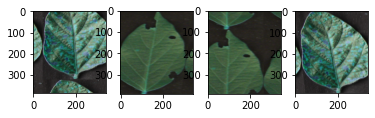

In [35]:
#Image transformations using respective function with random inputs
def rotation(img):
    angle=random.randint(0,359)
    img=rotate(img,angle)
    return img
def scale(img):
    width=np.arange(10,img.shape[0],20)
    height=np.arange(10,img.shape[1],20)
    w,h=random.choice(width),random.choice(height)
    resized_img = cv2.resize(img, (w, h))
    img =np.uint8(resized_img)
    return img
def shift(img):
    horizontal_shift=random.randint(-1*img.shape[0],img.shape[0])
    vertical_shift=random.randint(-1*img.shape[1],img.shape[1])
    transform=AffineTransform(translation=(horizontal_shift,vertical_shift))
    img=warp(img,transform,mode='wrap')
    return img
def warping(img):
    shear_factor=random.uniform(-0.5,0.5)
    transform = AffineTransform(shear=shear_factor)
    img=warp(img,transform,mode='wrap')
    return img

#Reading the images 
images=[]
files=os.listdir('/content/leaves/')
for i in files:
    image=cv2.imread('/content/leaves/'+i)
    images.append(image)
    
#Choosing transformation functions randomly and performing augmentation
number_of_aug=100
aug_data=[]
for i in range(0,number_of_aug):
    image_no=random.randint(0, len(images)-1)  
    image=images[image_no]
    transformations=['rotate','scale','shift','warp']
    transform_choice=random.choice(transformations)
    if(transform_choice=='rotate'):
        aug_image=rotation(image)
    elif(transform_choice=='scale'):
        aug_image=scale(image)
    elif(transform_choice=='shift'):
        aug_image=shift(image)
    else:
        aug_image=warping(image)
    aug_data.append(aug_image)
    #Saving the transformed images
    plt.imsave('/content/transformed/'+str(i)+'.png',aug_image)
#Displaying the augmented images
plt.figure()
f, axarr = plt.subplots(1,4) 
axarr[0].imshow(aug_data[0])
axarr[1].imshow(aug_data[1])
axarr[2].imshow(aug_data[2])
axarr[3].imshow(aug_data[3])


# Performing image augmentation using keras' ImageDataGenerator
for i in range(0,number_of_aug+1):
    image_no=random.randint(0, len(images)-1)  
    image=images[image_no]
    image=np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
    datagen=keras.preprocessing.image.ImageDataGenerator(
		rotation_range=180,
		zoom_range=0.2,
		width_shift_range=0.3,
		height_shift_range=0.3,
		shear_range=0.2,
		horizontal_flip=True,
        vertical_flip=True)
    data_iter = datagen.flow(image, batch_size=1)
    aug_image = next(data_iter)[0].astype('uint8')
    cv2.imwrite('content/transformed/'+str(i)+'.png',aug_image)

Question 1.2

<Figure size 432x288 with 0 Axes>

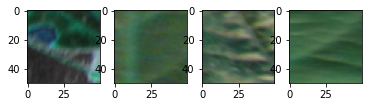

In [37]:

width=50
height=50
#Reading the input images
files=os.listdir('/content/leaves/')
def p_check(mask,start_x,start_y):
    #Selecting patches only from the leaf is present (i.e. not the background)
    ROI=mask[start_x:start_x+width,start_y:start_y+height]
    #Calculating percentage of whiteness
    if(np.sum(ROI==255)/(ROI.shape[0]*ROI.shape[1])>0.7):
        return True
    else:
        return False
patches=[]
for i in range(0,len(files)):
    image=cv2.imread('/content/leaves/'+files[i])
    hsv=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)[:,:,2]
    ret,image_result = cv2.threshold(hsv,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
    image_result= cv2.morphologyEx(image_result, cv2.MORPH_DILATE, kernel, )

    contours = cv2.findContours(image_result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    c = max(contours, key = cv2.contourArea)
    start_x=random.randint(0,image.shape[0]-50)
    start_y=random.randint(0,image.shape[1]-50)
    while(not p_check(image_result,start_x,start_y)):
        start_x=random.randint(0,image.shape[0]-50)
        start_y=random.randint(0,image.shape[1]-50)
        
    else:
        ROI=image[start_x:start_x+width,start_y:start_y+height]
        patches.append(ROI)
     # Writing the patches obtained to a file   
    cv2.imwrite('content/patches/'+str(i+1)+'.png',ROI)
#Displaying patches extracted
plt.figure()
f, axarr = plt.subplots(1,4) 
axarr[0].imshow(patches[0])
axarr[1].imshow(patches[1])
axarr[2].imshow(patches[2])
axarr[3].imshow(patches[3])

Question 1.3

(32, 32, 3) 119
(32, 32, 3) 115
(32, 32, 3) 144
(32, 32, 3) 129
(32, 32, 3) 119
(32, 32, 3) 203
(32, 32, 3) 218
(32, 32, 3) 167
shape of array:  (8, 32, 32, 3)
eia: (8, 3072)
max eia: 218
eia max after normalizing:  1.0
eia mean:  0.38126160974531736
eia min after: -0.3916284403669724 eia max after: 0.5590596330275229
Shape of covariance matrix:  (3072, 3072)

shape: (3072, 3072)
min: 0.0
max: 1.0


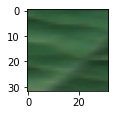

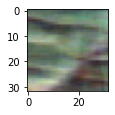


shape: (3072, 3072)
min: 0.0
max: 1.0


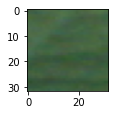

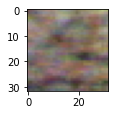

In [38]:
os.chdir('/content/')

# Specify the folder to find all images 
folder = glob("/content/patches/*")

def resize_image(img):
  return(cv2.resize(img,(32,32)))

def plotImage(X):
  plt.figure(figsize=(1.5, 1.5))
  plt.imshow(X.reshape(32,32,3))
  plt.show()
  plt.close()



# Initialize an empty list to store all the images data
eia=[]    

# loop through the folder to retrieve all images 
for file in range(len(folder)):
    img = cv2.imread(folder[file])
    img = resize_image(img)
    print(img.shape,img.max())
    eia.append(img)
eia_array = np.asarray(eia)
print("shape of array: ",eia_array.shape)


# Reshape the images/ flatten them
eia = eia_array.reshape(eia_array.shape[0],eia_array.shape[1]*eia_array.shape[2]*eia_array.shape[3])

print("eia:",eia.shape)

# normalize the data
print("max eia:",eia.max())
eia = eia / eia.max()

print("eia max after normalizing: ",eia.max())

# Subtract the mean from the normalized pixels  
print("eia mean: ", eia.mean())
eia = eia - eia.mean(axis=0)

print("eia min after:", eia.min(),"eia max after:", eia.max())
# Find the covariance of the pixels

cov = np.cov(eia,rowvar=False)
print("Shape of covariance matrix: ", cov.shape)


U,S,V = np.linalg.svd(cov)
# print( np.diag(S))
print ('\nshape:', np.diag(S).shape)

epsilon = 0.1
X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(eia.T).T
X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
print ('min:', X_ZCA_rescaled.min())
print ('max:', X_ZCA_rescaled.max())

# Epsilon = 0.1

plotImage(eia_array[3, :])
plotImage(X_ZCA_rescaled[3, :])


\


U,S,V = np.linalg.svd(cov)
print ('\nshape:', np.diag(S).shape)

epsilon = 0.8
X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(eia.T).T
X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
print ('min:', X_ZCA_rescaled.min())
print ('max:', X_ZCA_rescaled.max())


plotImage(eia_array[0, :])
plotImage(X_ZCA_rescaled[0, :])

Question 1.4

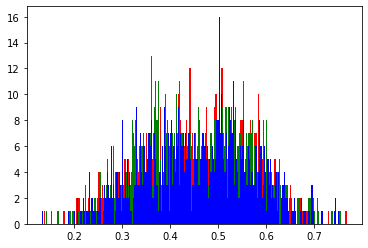

In [39]:
#Plotting channel distributions of the pre-whitened images
#Reshaping pre whitened images
X_ZCA_reshaped=np.reshape(X_ZCA_rescaled,(-1,eia_array.shape[1],eia_array.shape[2],eia_array.shape[3]))
_ = plt.hist(X_ZCA_reshaped[:, :, 0].ravel(), bins = 256, color = 'red')
_ = plt.hist(X_ZCA_reshaped[:, :, 1].ravel(), bins = 256, color = 'Green')
_ = plt.hist(X_ZCA_reshaped[:, :, 2].ravel(), bins = 256, color = 'Blue')

Question 1.5

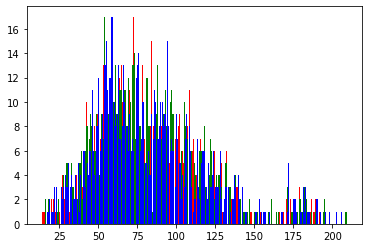

In [40]:
#Plotting channel distributions of the original images
_ = plt.hist(eia_array[:, :, 0].ravel(), bins = 256, color = 'red')
_ = plt.hist(eia_array[:, :, 1].ravel(), bins = 256, color = 'Green')
_ = plt.hist(eia_array[:, :, 2].ravel(), bins = 256, color = 'Blue')